# Test of mapping 2D points to the 3D model
- Uses the UV mapping of the right arm to select the 3D point
- For this test, I select locations on the 2D image using openCV to click on points

## Inital Setup

### Import libraries

In [1]:
import potpourri3d as pp3d
import polyscope as ps
import cv2
import pandas as pd
import numpy as np

### Start Polyscope to visualize the mesh

In [2]:
ps.init()

### Import in the right hand

In [3]:
V, F = pp3d.read_mesh("../Models/Male Right Arm UV Mapped.obj")

### Add the surface mesh to Polyscope

In [4]:
ps_mesh = ps.register_surface_mesh("mesh", V, F)

### Set up a stateful solver
This is much faster on repeated computations

In [5]:
solver = pp3d.MeshHeatMethodDistanceSolver(V,F)

## Find 2D points from right arm image

### Load in the right arm mesh data and split it up

In [6]:
mesh_data = pd.read_csv("../Models/Male Right Arm UV Mapped as Text.txt", names = ["Type", "Point 1", "Point 2", "Point 3"], delim_whitespace = True, dtype = str)
mesh_data.describe()

,Type,Point 1,Point 2,Point 3
count,1254063,1254063,1254063,1040000
unique,4,810567,790349,617708
top,f,-0.9988,-0.1328,-0.9999
freq,416256,86,94,196


In [7]:
grouped_mesh_data = mesh_data.groupby(["Type"])
grouped_mesh_data.describe()

Point 1                               Point 2          \
       count  unique              top freq   count  unique   
Type                                                         
f     416256  415764  7414/7622/23239    2  416256  416061   
v     208529  197533        -2.451381    4  208529  202747   
vn    415215   20001          -0.9988   86  415215   19933   
vt    214063  177269         0.255370    7  214063  154753   

                                Point 3                                     
                       top freq   count  unique                   top freq  
Type                                                                        
f     145345/148899/136200    2  416256  416051  170358/174691/164662    2  
v                -3.167251    4  208529  181656             -0.698178    6  
vn                 -0.1328   94  415215   20001               -0.9999  196  
vt                0.943563   10       0       0                   NaN  NaN

#### Extract out the vertex data

In [8]:
vertex_data = grouped_mesh_data.get_group("v")
vertex_data = vertex_data.astype({"Point 1" : float, "Point 2" : float, "Point 3" : float})
vertex_data.drop("Type", axis = 1, inplace = True)
vertex_data.rename(columns = {"Point 1" : "x", "Point 2" : "y", "Point 3" : "z"}, inplace = True)
vertex_data.reset_index(drop = True, inplace = True)
vertex_data.index += 1
vertex_data.head()

,x,y,z
1,0.013838,3.039812,-0.910372
2,-0.000184,2.673386,0.558873
3,0.002837,0.350154,-0.912598
4,0.006835,1.589682,-1.169296
5,-0.009337,1.241935,0.602611


In [9]:
vertex_data.describe()

,x,y,z
count,208529.000000,208529.000000,208529.000000
mean,-2.191932,-1.074596,-0.514607
std,0.861022,2.256397,0.398661
min,-3.478783,-3.551993,-1.210523
25%,-2.828356,-3.010106,-0.705876
50%,-2.429812,-2.258329,-0.610621
75%,-1.717123,1.004798,-0.466818
max,0.024568,3.587607,0.900949


#### Extract out the normal vectors of each face

In [10]:
normal_data = grouped_mesh_data.get_group("vn")
normal_data = normal_data.astype({"Point 1" : float, "Point 2" : float, "Point 3" : float})
normal_data.drop("Type", axis = 1, inplace = True)
normal_data.rename(columns = {"Point 1" : "x", "Point 2" : "y", "Point 3" : "z"}, inplace = True)
normal_data.reset_index(drop = True, inplace = True)
normal_data.index += 1
normal_data.head()

,x,y,z
1,-0.8396,0.4261,0.3367
2,-0.8312,0.4198,0.3645
3,-0.8230,0.4124,0.3906
4,-0.8151,0.4043,0.4149
5,-0.8078,0.3966,0.4362


In [11]:
normal_data.describe()

,x,y,z
count,415215.000000,415215.000000,415215.000000
mean,-0.087120,-0.023133,0.016830
std,0.597854,0.339889,0.720167
min,-1.000000,-1.000000,-1.000000
25%,-0.607700,-0.216000,-0.734800
50%,-0.104700,-0.053700,0.052200
75%,0.365850,0.144700,0.752700
max,1.000000,1.000000,1.000000


#### Get the UV coordinates for each 3D face on the 2D drawings

In [12]:
uv_data = grouped_mesh_data.get_group("vt")
uv_data = uv_data.astype({"Point 1" : float, "Point 2" : float, "Point 3" : float})
uv_data.drop("Type", axis = 1, inplace = True)
uv_data.drop("Point 3", axis = 1, inplace = True)
uv_data.rename(columns = {"Point 1" : "x", "Point 2" : "y"}, inplace = True)
uv_data.reset_index(drop = True, inplace = True)
uv_data.index += 1
uv_data.head()

,x,y
1,0.180526,0.293299
2,0.810420,0.591722
3,0.183464,0.069155
4,0.182302,0.172520
5,0.806098,0.486308


In [13]:
uv_data.describe()

,x,y
count,214063.000000,214063.000000
mean,0.492508,0.731076
std,0.243970,0.279442
min,0.139781,0.045819
25%,0.252630,0.502533
50%,0.468235,0.898770
75%,0.734793,0.945013
max,0.865236,0.983104


#### Extract out the face data.
Faces are special in that each column is divided into the form of vertex/UV vertex/normal vector for each point of the face

In [14]:
face_data = grouped_mesh_data.get_group("f")
#face_data.drop("Type", axis = 1, inplace = True)
split_face_data_1 = pd.DataFrame()
split_face_data_1[["vertex", "uv", "normal"]] = face_data["Point 1"].str.split("/", expand = True)
split_face_data_2 = pd.DataFrame()
split_face_data_2[["vertex", "uv", "normal"]] = face_data["Point 2"].str.split("/", expand = True)
split_face_data_3 = pd.DataFrame()
split_face_data_3[["vertex", "uv", "normal"]] = face_data["Point 3"].str.split("/", expand = True)
split_face_data = pd.concat([split_face_data_1, split_face_data_2, split_face_data_3])
split_face_data = split_face_data.astype({"vertex" : float, "uv" : float, "normal" : float})
face_data = split_face_data.reset_index(drop = True)
face_data.index += 1
face_data.head()

,vertex,uv,normal
1,25606.0,26611.0,1.0
2,25607.0,26612.0,2.0
3,25608.0,26613.0,3.0
4,25609.0,26614.0,4.0
5,25610.0,26615.0,5.0


In [15]:
face_data.describe()

,vertex,uv,normal
count,1.248768e+06,1.248768e+06,1.248768e+06
mean,1.044559e+05,1.070939e+05,2.073675e+05
std,6.009887e+04,6.159994e+04,1.198627e+05
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,5.243500e+04,5.394500e+04,1.035408e+05
50%,1.044675e+05,1.065905e+05,2.071505e+05
75%,1.564980e+05,1.603440e+05,3.111692e+05
max,2.085290e+05,2.140630e+05,4.152150e+05


## Setup code to get UV points from the location images

### Find Starting Point (Thumb in Example)

In [16]:
def click_event(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x, ' ', y)
        global click_x, click_y
        click_x, click_y = x, y

In [17]:
img = cv2.imread('../Media/right arm.png', 1)
image_x_size = img.shape[1]
image_y_size = img.shape[0]

In [18]:
scale_factor = 9
img = cv2.resize(img, (int(image_x_size / scale_factor), int(image_y_size / scale_factor)))
cv2.imshow('image', img)
click_x, click_y = -1, -1
cv2.setMouseCallback('image', click_event)
cv2.waitKey(0)
cv2.destroyAllWindows()

126   71


#### Find the nearest UV point to that clicked point

In [19]:
normalized_x = click_x / image_x_size * scale_factor
normalized_y = click_y / image_y_size * scale_factor
desired_location = np.array([normalized_x, 1 - normalized_y])
print(desired_location)

[0.35393258 0.93444137]


In [20]:
uv_array = uv_data.values
distances_to_uvs = np.linalg.norm(uv_array - desired_location, axis = 1)
nearest_uv_id = distances_to_uvs.argsort()[0]
print(uv_data.iloc[[nearest_uv_id]])

             x         y
14002  0.35406  0.934581


#### Get the vertex number from the UV number

In [21]:
start_vertex_id = int(face_data.loc[face_data["uv"] == nearest_uv_id]["vertex"].values[0])-1
print(start_vertex_id)

13479


### Find the Ending Vertex (Middle Finger in my example) by doing all the steps again

In [22]:
# Show image again and get click location
cv2.imshow('image', img)
click_x, click_y = -1, -1
cv2.setMouseCallback('image', click_event)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Convert that to a normalized location on the image
normalized_x = click_x / image_x_size * scale_factor
normalized_y = click_y / image_y_size * scale_factor
desired_location = np.array([normalized_x, 1 - normalized_y])

# Find the closest UV to that point
distances_to_uvs = np.linalg.norm(uv_array - desired_location, axis = 1)
nearest_uv_id = distances_to_uvs.argsort()[0]

# Find the 3D vertex from that UV point as the ending vertex
end_vertex_id = int(face_data.loc[face_data["uv"] == nearest_uv_id]["vertex"].values[0])-1
print(end_vertex_id)

86   25
147273


## Use the Start and End Verticies to Trace a Path

### Plot the distance first

In [23]:
path_verticies = [start_vertex_id, end_vertex_id]
dist = solver.compute_distance_multisource([start_vertex_id, end_vertex_id])
ps_mesh.add_distance_quantity("dist", dist, enabled = True, stripe_size = 0.01)

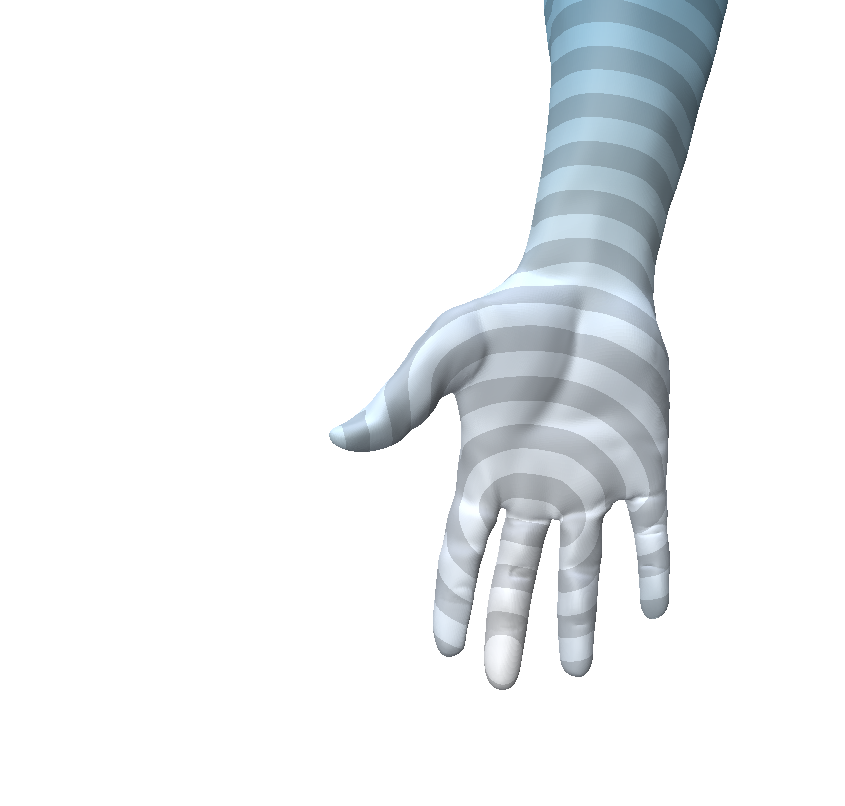

### Find the Path

In [24]:
# Flip geodesics
path_solver = pp3d.EdgeFlipGeodesicSolver(V,F)
path_points = path_solver.find_geodesic_path_poly(path_verticies)
ps.register_curve_network("Geodesic Path", path_points, edges='line')
ps.show()

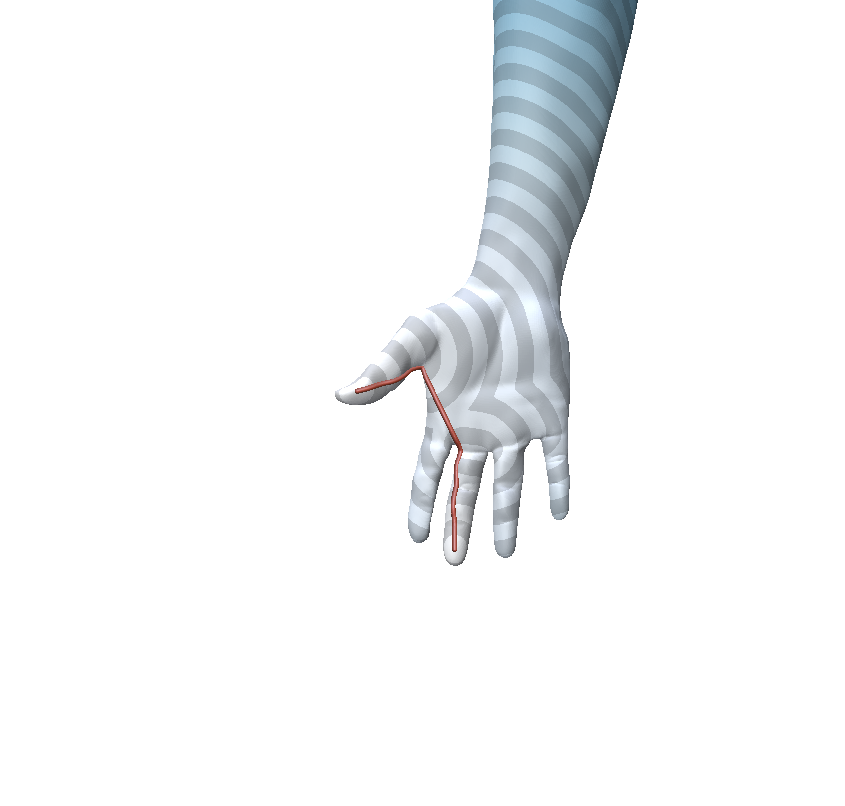